#### Define libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

#### Define the hydro class

In [2]:
class void():
    """ Empty class, used to create ad hoc objects """
    pass

class hd():
    """ Template class for hydrodynamics, with parameters, variables and methods """
    def __init__(self,n=64,gamma=1.4,Lbox=2.,cs=None):
        """ Initialization of arrays for conservative variables """
        self.n=n                     # number of points along a coordinate axis. n*n in total
        self.Lbox=Lbox               # box size
        self.t = 0.                  # time
        self.it = 0                  # iterations
        self.gamma = gamma           # adiabatic index
        if gamma==1:                 # only set sound speed if gas isothermal
            self.cs = cs
        self.rho   = np.ones((n,n))  # density
        self.Etot  = np.ones((n,n))  # total energy
        self.Px    = np.zeros((n,n)) # momentum in x-direction
        self.Py    = np.zeros((n,n)) # momentum in y-direction
        self.coordinates()           # setup cooridnate system
    
    def coordinates(self):
        """ Coordinate initialization """
        n = self.n              # shorthand, used a lot below
        self.ds = self.Lbox/n
        self.dx = self.ds
        self.dy = self.ds
        # cell-centered coordinates are in the interval [-1+ds/2,...,1-ds/2]
        self.x = np.linspace(-self.Lbox*0.5,self.Lbox*0.5,num=self.n,endpoint=False)+0.5*self.ds 
        self.y = self.x
        # make a 2D radius function for convenience
        self.r = np.zeros((n,n))
        for i in range(n):
            self.r[i] = (self.y**2 + self.x[i]**2)**0.5 
        return self.ds,self.r
    def velocity(self):
        """ Compute velocity from conservative variables and return in (2,n,n) array """
        return np.array([self.Px/self.rho, self.Py/self.rho])

    def pressure(self):
        """ Compute pressure from conservative variables """
        if (self.gamma==1.0):
            P = self.cs**2 * self.rho
        else:
            Eint = self.Etot - 0.5*(self.Px**2 + self.Py**2)/self.rho 
            P = (self.gamma-1.)*Eint
        return P

    def temperature(self):
        """ Compute the 'temperature', defined as P/rho = kB / mu T """
        return self.pressure() / self.rho
    
    def Courant(self,C=0.5):
        """ Courant condition for HD """
        v = self.velocity()
        speed = np.sqrt(v[0]**2 + v[1]**2)
        cs = np.sqrt(self.gamma*self.pressure()/self.rho)
        return C*self.ds/np.max(cs+speed)

$\bf Task\ 1$

#### Define usefull functions 

In [3]:
# Conservative variables computed from primitve variable
def primitive_to_conservative(q):
    U = void()
    U.D  = q.D
    U.mU = q.D*q.U #for the x dimension of velocity
    U.mV = q.D*q.V #for the y dimension of velocity
    if q.gamma != 1: 
        Eint=q.P/(q.gamma-1.)
        U.Etot = Eint+0.5*(q.D*(q.U**2+q.V**2)) #for the total energy
    return U

# Hydro flux from conservative and primitive variables
def Hydro_Flux(q,U):
    F = void()
    F.D = U.mU
    F.mU = U.mU*q.U + q.P #for the flux in the x direction
    F.mV = U.mV*q.U #for the flux in the y direction
    if q.gamma != 1:
        F.Etot = U.Etot*(q.U)+q.P*(q.U) #for the energy flux
    return F
def LLF(ql,qr):
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P/ql.D)**0.5
    c_right = (qr.gamma*qr.P/qr.D)**0.5
    c_max = np.maximum (c_left, c_right)
    
    # maximum propagation speed anywhere
    cmax = np.maximum (np.abs(ql.U)+c_max, np.abs(qr.U)+c_max)

    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)
    
    # LLF flux based on maximum wavespeed.
    # The general form is 
    #   (F_left + F_right - cmax*(U_right - U_left)) / 2
    # where U = (rho, rho*U, rho*V, E_tot) are the conserved variables
    Flux = void()
    Flux.D  = 0.5*(Fl.D  + Fr.D  - cmax*(Ur.D  - Ul.D))
    Flux.mU = 0.5*(Fl.mU + Fr.mU - cmax*(Ur.mU - Ul.mU))
    Flux.mV = 0.5*(Fl.mV + Fr.mV - cmax*(Ur.mV - Ul.mV))
    if ql.gamma != 1:
        Flux.Etot = 0.5*(Fl.Etot + Fr.Etot - cmax*(Ur.Etot - Ul.Etot))

    return Flux
def HLL(ql,qr):
    # sound speed for each side of interface (l==left, r==right), and maxmimum sound speed (c_max)
    c_left  = (ql.gamma*ql.P/ql.D)**0.5
    c_right = (qr.gamma*qr.P/qr.D)**0.5
    c_max = np.maximum (c_left, c_right)
   

    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)
    # maximum wave speeds to the left and right (guaranteed to have correct sign)
    SL = np.minimum(np.minimum(ql.U,qr.U)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.U,qr.U)+c_max,0) # >= 0.
    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)

    # HLL flux based on wavespeeds. If SL < 0 and SR > 0 then mix state appropriately
    # The general form is 
    #    (SR * F_left - SL * F_right + SL * SR *(U_right - U_left)) / (SR - SL)
    # where U is the state vector of the conserved variables
    Flux = void()
    Flux.D = (SR*Fl.D-SL*Fr.D+SL*SR*(Ur.D-Ul.D))/(SR-SL)
    Flux.mU = (SR*Fl.mU-SL*Fr.mU+SL*SR*(Ur.mU-Ul.mU))/(SR-SL)
    Flux.mV = (SR*Fl.mV-SL*Fr.mV+SL*SR*(Ur.mV-Ul.mV))/(SR-SL)
    if ql.gamma != 1:
        Flux.Etot = (SR*Fl.Etot-SL*Fr.Etot+SL*SR*(Ur.Etot-Ul.Etot))/(SR-SL)
        
    return Flux
def left_slope(f,axis=0):
    return (f-np.roll(f,1,axis))

def MonCen(f):
    """ Monotonized central slope limiter """
    if f.ndim==1:
        ls=left_slope(f)
        rs=np.roll(ls,-1)
        cs=np.zeros(ls.shape)
        w=np.where(ls*rs>0.0)
        cs[w]=2.0*ls[w]*rs[w]/(ls[w]+rs[w])
        return cs
    else:
        shape=np.insert(f.shape,0,f.ndim)
        slopes=np.zeros(shape)
        for i in range(f.ndim):
            ls=left_slope(f,axis=i)
            rs=np.roll(ls,-1,axis=i)
            cs=np.zeros(f.shape)
            w=np.where(ls*rs>0.0)
            cs[w]=2.0*ls[w]*rs[w]/(ls[w]+rs[w])
            slopes[i]=cs
        return slopes
def muscl_2d (u, dt, Slope=MonCen, Riemann_Solver=HLL):
    ds   = u.ds
    ids  = 1. / u.ds # 1 / cell size, useful for derivatives below
    dtds = dt/u.ds
    

    # 1) Compute primitive variables (rho, v, P)
    # make sure to copy u.rho to D, otherwise D becomes a "pointer" to u.rho, and updates itself in 7)
    D = np.copy(u.rho)         # D: density (n,n)
    v = u.velocity()           # v: velocity (2,n,n)
    P = u.pressure()           # P: pressure (n,n)
    # 2) Compute slope limited derivatives based on centered points
    dD = Slope(D) * ids        # returns (2,n,n) 
    dP = Slope(P) * ids        # returns (2,n,n)
    dv0 = Slope(v[0]) * ids    # returns (2,n,n)
    dv1 = Slope(v[1]) * ids    # returns (2,n,n)
    dv = np.array([dv0,dv1])   # shape = (2,2,n,n)

    # 3) Trace forward to find solution at [t+dt/2, x +- dx/2]
    
    # Time evolution with source terms
    div = dv[0,0] + dv[1,1] # div(v)
    D_t = - v[0]*dD[0] - v[1]*dD[1] - D*div  # dD/dt = -v*grad(D) - D*div(v)
    P_t = - v[0]*dP[0] - v[1]*dP[1] - u.gamma*P*div   # dP/dt = -v*grad(P) - gamma*P*div(v)
    v_t = np.empty_like(v)                   # create empty array with shape = (2,n,n)
    v_t[0] = - v[0]*dv[0,0] - v[1]*dv[0,1] - dP[0]/D  # dv/dt = -v*grad(v) - grad(P)/D
    v_t[1] = - v[0]*dv[1,0] - v[1]*dv[1,1] - dP[1]/D
    # Loop over X- and Y-direction
    for axis in range(2):
        ql = void(); ql.gamma = u.gamma
        qr = void(); qr.gamma = u.gamma
        
        # Calculates the parallel and perpendicular velocities to the coordinate direction
        # X-axis: iu=0, iv=1, Y-axis: iu=1, iv=0
        iu = axis
        iv = (axis + 1) % 2
        # Parallel (U) and perpendicular (V) velocities
        U = v[iu]; dU = dv[iu]; U_t = v_t[iu]
        V = v[iv]; dV = dv[iv]; V_t = v_t[iv]

        # 4) Spatial interpolation "axis"-direction + time terms

        # left state -- AS SEEN FROM THE INTERFACE
        ql.D = D + 0.5*(dt*D_t + ds*dD[axis])
        ql.P = P + 0.5*(dt*P_t + ds*dP[axis]) 
        ql.U = U + 0.5*(dt*U_t + ds*dU[axis])
        ql.V = V + 0.5*(dt*V_t + ds*dV[axis])
        

        # right state -- AS SEEN FROM THE INTERFACE
        qr.D = D + 0.5*(dt*D_t - ds*dD[axis])
        qr.P = P + 0.5*(dt*P_t - ds*dP[axis])
        qr.U = U + 0.5*(dt*U_t - ds*dU[axis])
        qr.V = V + 0.5*(dt*V_t - ds*dV[axis])

        # 5) Roll down -1 in the "axis" direction so that we collect
        #    left and right state (as seen from the interface) at the same grid index
        qr.D = np.roll(qr.D,-1,axis=axis)
        qr.P = np.roll(qr.P,-1,axis=axis)
        qr.U = np.roll(qr.U,-1,axis=axis)
        qr.V = np.roll(qr.V,-1,axis=axis)

        # 6) Solve for flux based on interface values
        Flux = Riemann_Solver(ql,qr)

        # 7) Update conserved variables with fluxes
        u.rho  -= dtds * (Flux.D - np.roll(Flux.D,1,axis=axis))
        if u.gamma != 1:
            u.Etot -= dtds * (Flux.Etot - np.roll(Flux.Etot,1,axis=axis))
        if axis==0: # X-axis
            u.Px   -= dtds * (Flux.mU - np.roll(Flux.mU,1,axis=axis))
            u.Py   -= dtds * (Flux.mV - np.roll(Flux.mV,1,axis=axis))
        if axis==1: # Y-axis
            u.Px   -= dtds * (Flux.mV - np.roll(Flux.mV,1,axis=axis))
            u.Py   -= dtds * (Flux.mU - np.roll(Flux.mU,1,axis=axis))

    u.t  += dt # update time
    u.it += 1  # update number of iterations

    return u

$\bf Task\ 2$

#### Define the blast wave class

In [4]:
class blast_wave(hd):
    def __init__(u,n=64,gamma=1.4,e0=1e3,d0=0.0,power=2,w=3.,eps=0.05):
        hd.__init__(u,n)
        u.gamma = gamma
        u.rho  = np.ones((n,n))
        exponent=(np.exp(-u.r/(w*u.ds)))**power
        B=1/np.sum(exponent*u.ds*u.ds)
        profile =B*e0*exponent
        u.Etot = np.ones((n,n)) + profile

In [5]:
def imshow(f,size=10,axis=None):
    plt.figure(figsize=(size,size))
    if axis is None:
        extent = None
    else:
        extent = ([axis.min(), axis.max(), axis.min(), axis.max()])

    plt.imshow(np.transpose(f),origin='lower',extent=extent)
    plt.colorbar();
def title(e0=1e5,d0=1.0,C=0.5,n=128,solver=HLL):
    plt.title('e0={:.0e}   d0={:.0e}   C={:.1f}  n={}  {}'.format(e0,d0,C,n,solver.__name__));

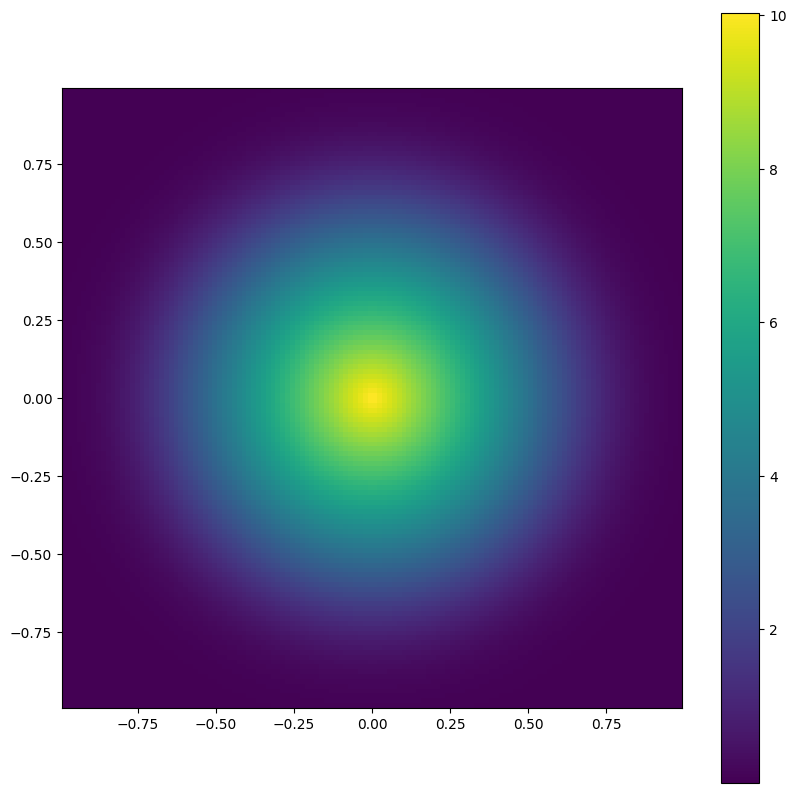

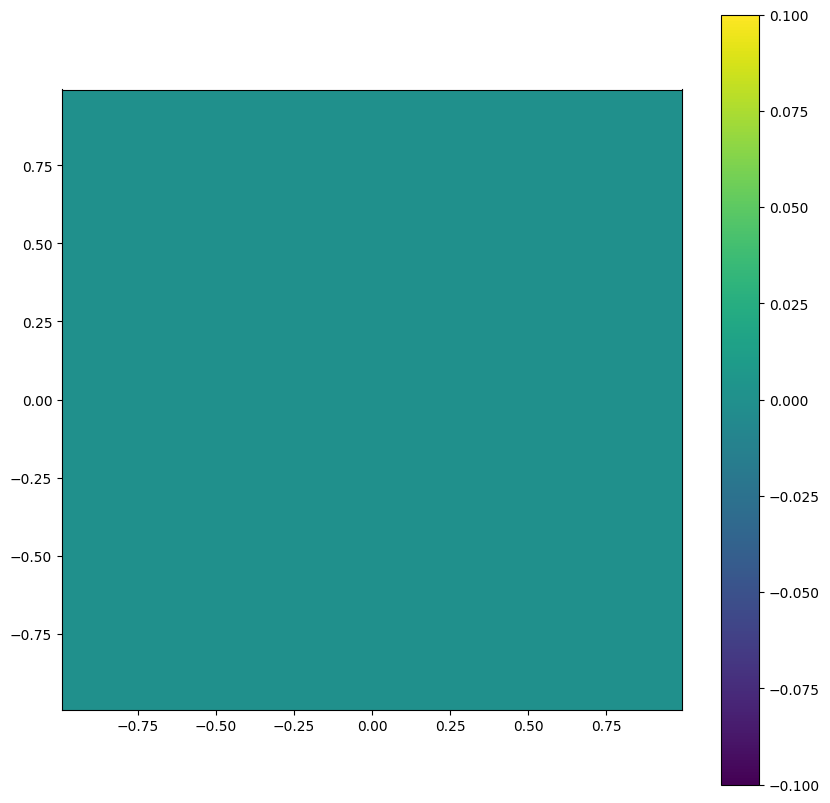

In [6]:
u = blast_wave(n=128,w=10)
imshow(np.log(u.Etot),axis=u.x)
imshow(np.log(u.rho),axis=u.x)

24.5 sec, 0.91 microseconds/update


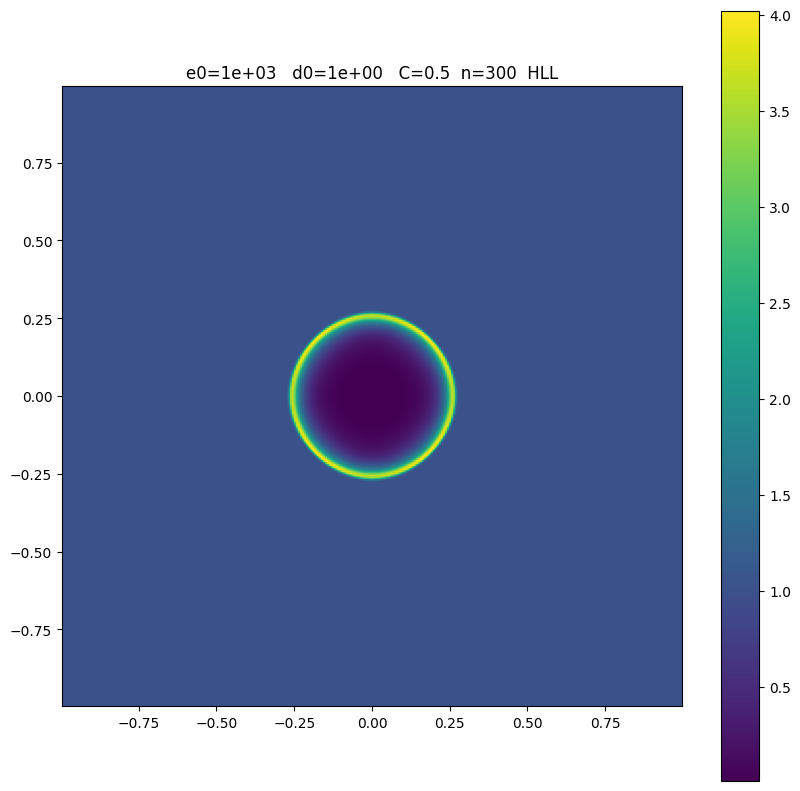

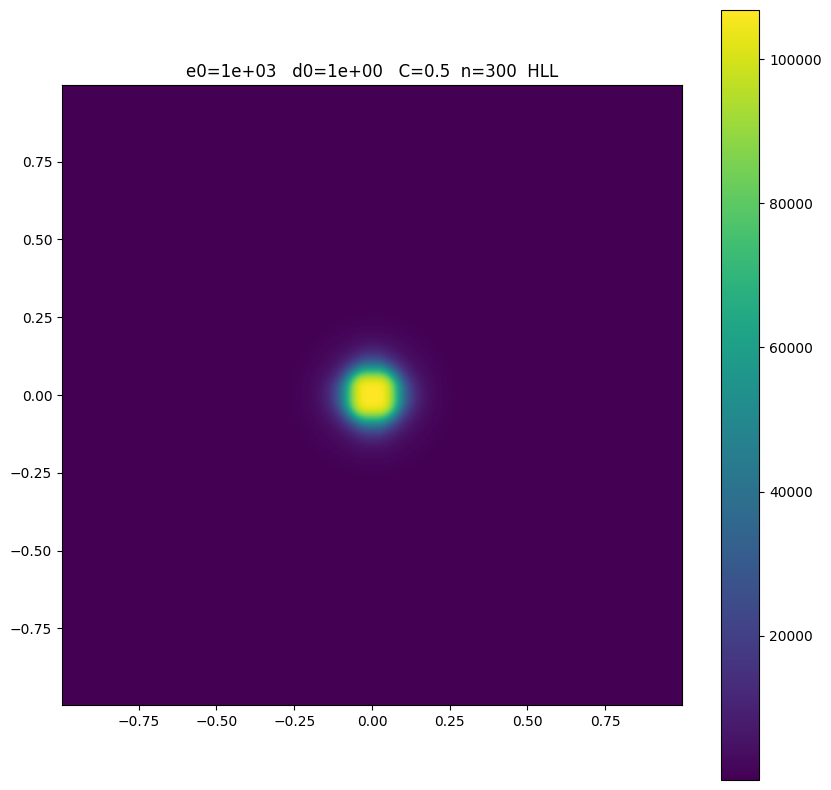

In [7]:
e0 = 1e3
n = 300
C = 0.5
nt = 300
solver = HLL
u = blast_wave(n=n,e0=e0,gamma=1.4,w=3.,power=4,eps=0.1)
start = time()
u_sol=[]
ut_sol=[]
uE_sol=[]
for it in range(nt):
    dt=u.Courant(C)
    u = muscl_2d(u,dt,Slope=MonCen,Riemann_Solver=solver)
    u_sol.append(np.copy(u.rho))
    ut_sol.append(np.copy(u.t))
    uE_sol.append(np.copy(u.Etot))

u_sol=np.asarray(u_sol)
shock_front=np.ones(len(u_sol))
for i, sol in enumerate(u_sol):
    index=np.unravel_index(np.argmax(sol),sol.shape)
    shock_front[i]=u.r[index]
    
    
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*nt)))
imshow(u.rho,axis=u.x)
title(e0=e0,C=C,n=n,solver=solver)
imshow(u.temperature(),axis=u.x)
title(e0=e0,C=C,n=n,solver=solver)

#plt.loglog(ut_sol,shock_front)
#plt.show()


16.4 sec, 0.61 microseconds/update


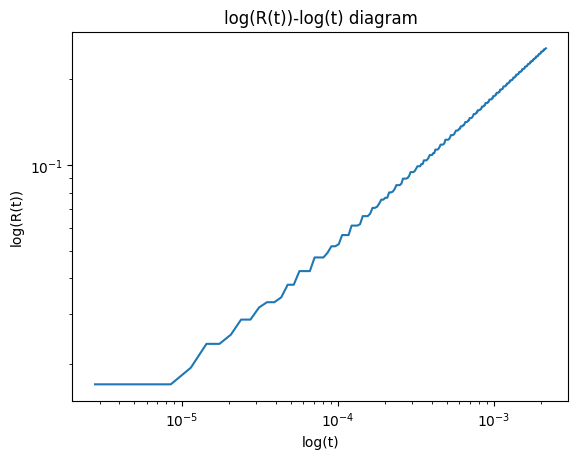

The slope is:  0.4919748027331004


In [8]:
e0 = 1e3
m0=0.5
n = 300
C = 0.5
nt = 300
solver = HLL
u = blast_wave(n=n,e0=e0,gamma=1.4,w=3.,power=4,eps=0.1)
start = time()
u_sol=[]
ut_sol=[]
uE_sol=[]
for it in range(nt):
    dt=u.Courant(C)
    u = muscl_2d(u,dt,Slope=MonCen,Riemann_Solver=solver)
    u_sol.append(np.copy(u.rho))
    ut_sol.append(np.copy(u.t))
    uE_sol.append(np.copy(u.Etot))

u_sol=np.asarray(u_sol)
shock_front=np.ones(len(u_sol))
for i, sol in enumerate(u_sol):
    index=np.unravel_index(np.argmax(sol),sol.shape)
    shock_front[i]=u.r[index]
       
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*nt)))
#imshow(u.rho,axis=u.x)
#title(e0=e0,C=C,n=n,solver=solver)
#imshow(u.temperature(),axis=u.x)
#title(e0=e0,C=C,n=n,solver=solver)

plt.loglog(ut_sol,shock_front)
plt.title('log(R(t))-log(t) diagram')
plt.xlabel('log(t)')
plt.ylabel('log(R(t))')
plt.show()

m, b = np. polyfit(np.log(ut_sol), np.log(shock_front), 1) 
print('The slope is: ', m)

$\bf Task\ 4$

#### Defintion of the new blast wave class which includes a profile in density as well

In [9]:
class blast_wave2(hd):
    def __init__(u,n=64,gamma=1.4,e0=1e3,d0=0.0,power=2,w=3.,eps=0.5,m0=0.5):
        hd.__init__(u,n)
        u.gamma = gamma
        exponent=(np.exp(-u.r/(w*u.ds)))**power
        B=1/np.sum(exponent*u.ds*u.ds)
        profile =B*e0*exponent
        profiled=B*m0*exponent
        u.Etot = np.ones((n,n)) + profile
        u.rho  = np.ones((n,n)) + profiled

In [10]:
def imshow(f,size=10,axis=None):
    plt.figure(figsize=(size,size))
    if axis is None:
        extent = None
    else:
        extent = ([axis.min(), axis.max(), axis.min(), axis.max()])

    plt.imshow(np.transpose(f),origin='lower',extent=extent)
    plt.colorbar();
def title(e0=1e5,d0=1.0,C=0.5,n=128,solver=HLL):
    plt.title('e0={:.0e}   d0={:.0e}   C={:.1f}  n={}  {}'.format(e0,d0,C,n,solver.__name__));

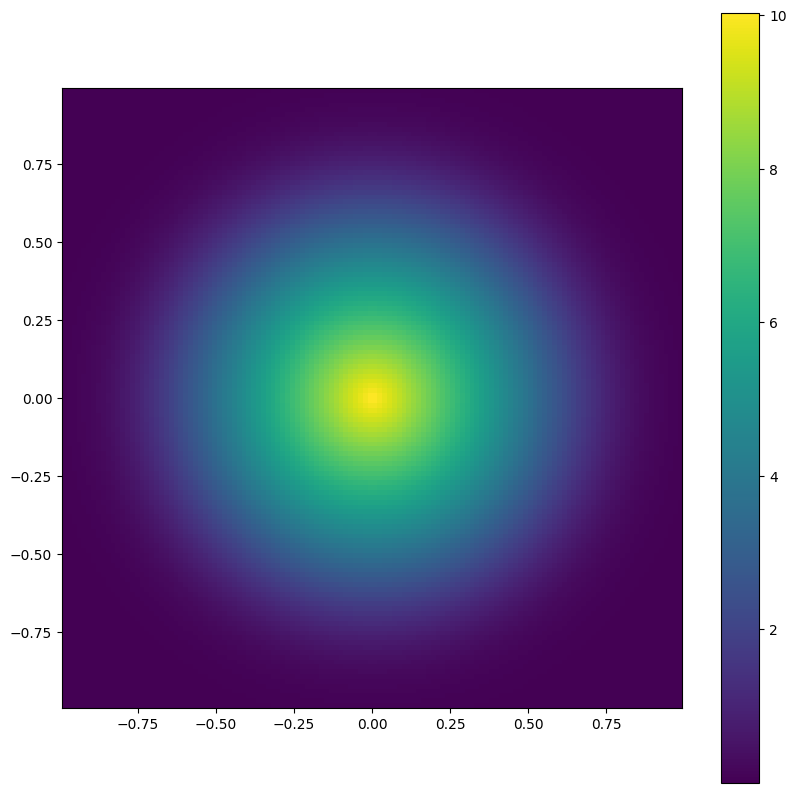

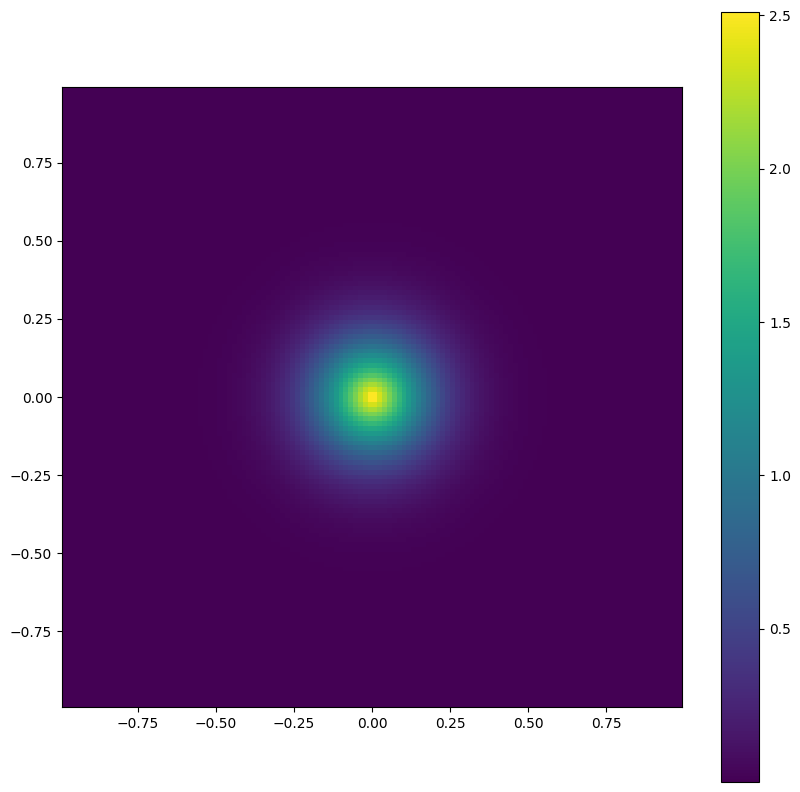

In [11]:
u = blast_wave2(n=128,w=10)
imshow(np.log(u.Etot),axis=u.x)
imshow(np.log(u.rho),axis=u.x)

The images above depicts the profile of energy and density

19.9 sec, 0.74 microseconds/update


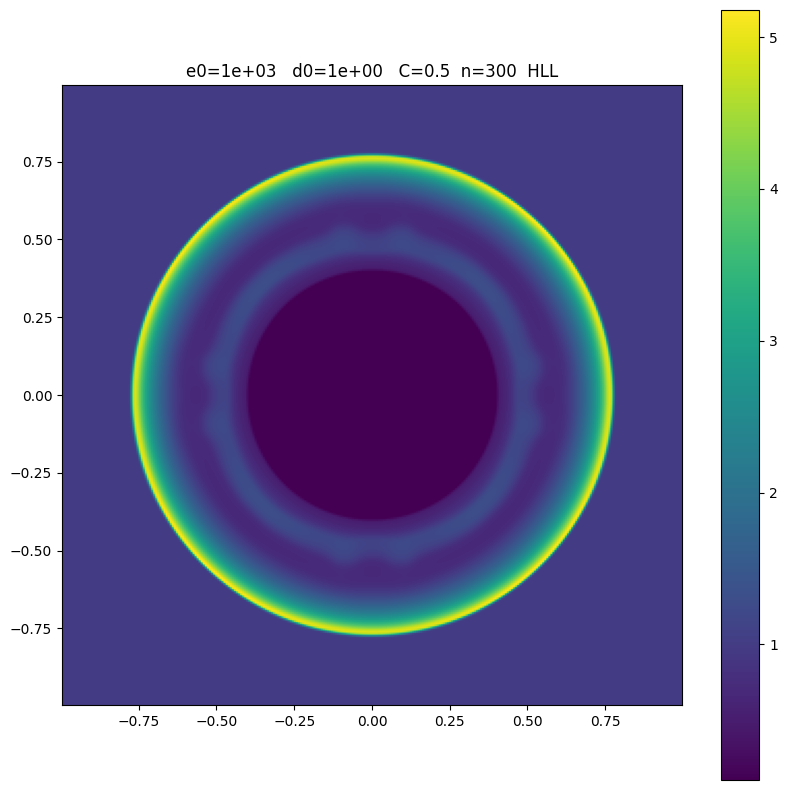

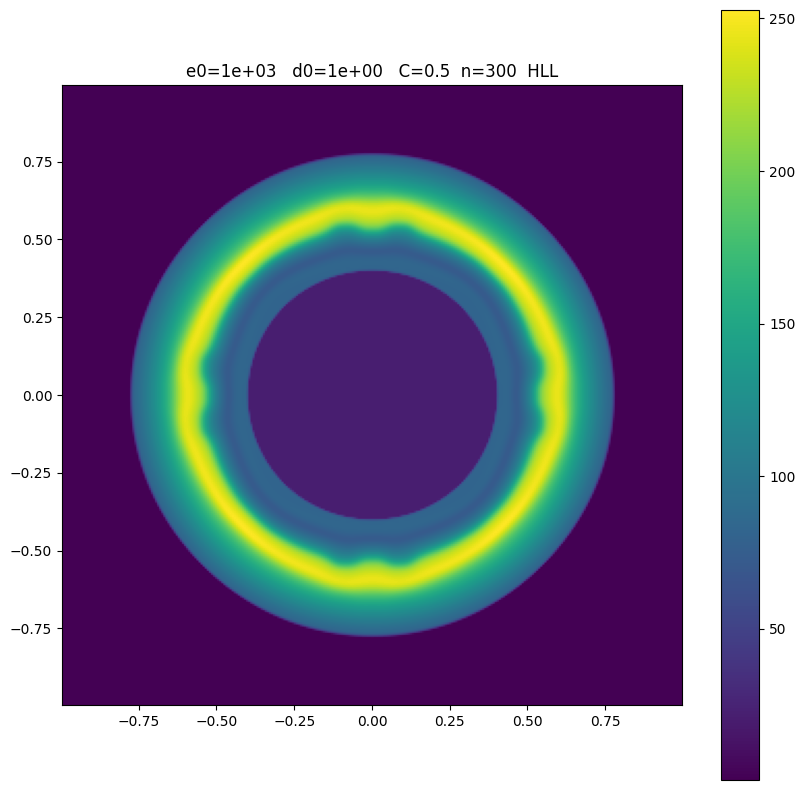

In [12]:
e0 = 1e3
m0=0.5
n = 300
C = 0.5
nt = 300
solver = HLL
u1 = blast_wave2(n=n,e0=e0,gamma=1.4,w=3.,power=4,eps=0.1)
start = time()
u1_sol=[]
u1t_sol=[]
u1E_sol=[]
for it in range(nt):
    dt=u1.Courant(C)
    u1 = muscl_2d(u1,dt,Slope=MonCen,Riemann_Solver=solver)
    u1_sol.append(np.copy(u.rho))
    u1t_sol.append(np.copy(u.t))
    u1E_sol.append(np.copy(u.Etot))

u1_sol=np.asarray(u1_sol)
shock_front1=np.ones(len(u1_sol))
for i, sol in enumerate(u1_sol):
    index=np.unravel_index(np.argmax(sol),sol.shape)
    shock_front1[i]=u1.r[index]
    
    
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*nt)))
imshow(u1.rho,axis=u1.x)
title(e0=e0,C=C,n=n,solver=solver)
imshow(u1.temperature(),axis=u1.x)
title(e0=e0,C=C,n=n,solver=solver)

#plt.loglog(ut_sol,shock_front)
#plt.show()


21.7 sec, 0.80 microseconds/update


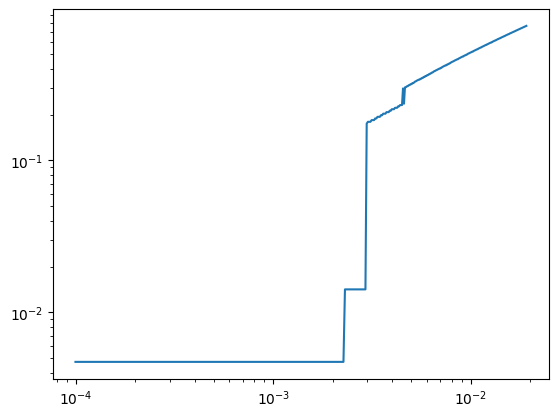

In [13]:
e0 = 1e3
m0=0.5
n = 300
C = 0.5
nt = 300
solver = HLL
u1 = blast_wave2(n=n,e0=e0,gamma=1.4,w=3.,power=4,eps=0.1)
start = time()
u1_sol=[]
u1t_sol=[]
u1E_sol=[]
for it in range(nt):
    dt=u1.Courant(C)
    u1 = muscl_2d(u1,dt,Slope=MonCen,Riemann_Solver=solver)
    u1_sol.append(np.copy(u1.rho))
    u1t_sol.append(np.copy(u1.t))
    u1E_sol.append(np.copy(u1.Etot))

u1_sol=np.asarray(u1_sol)
shock_front1=np.ones(len(u1_sol))
for i, sol in enumerate(u1_sol):
    index=np.unravel_index(np.argmax(sol),sol.shape)
    shock_front1[i]=u1.r[index]
    
    
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*nt)))
#imshow(u1.rho,axis=u1.x)
#title(e0=e0,C=C,n=n,solver=solver)
#imshow(u1.temperature(),axis=u1.x)
#title(e0=e0,C=C,n=n,solver=solver)

plt.loglog(u1t_sol,shock_front1)
plt.show()


The figures above show the blast wave and temperature for the blast wave, in the case of having a non-uniform density profile. The last image is correlated to the relation of the radius with time.

In [ ]:
''' This part of the is for the case of showning the Rayleigh Taylor instabilities that are produced. The results
are presented to the report (it takes some time for completing the run!!!!).
'''
e0 = 1e3
m0=0.5
n = 800
C = 0.5
nt = 900
solver = HLL
u = blast_wave2(n=n,e0=e0,gamma=1.4,w=3.,power=4,eps=0.5)
start = time()
u_sol=[]
ut_sol=[]
uE_sol=[]
for it in range(nt):
    dt=u.Courant(C)
    u = muscl_2d(u,dt,Slope=MonCen,Riemann_Solver=solver)
    u_sol.append(np.copy(u.rho))
    ut_sol.append(np.copy(u.t))
    uE_sol.append(np.copy(u.Etot))

u_sol=np.asarray(u_sol)
shock_front=np.ones(len(u_sol))
for i, sol in enumerate(u_sol):
    index=np.unravel_index(np.argmax(sol),sol.shape)
    shock_front[i]=u.r[index]
    
    
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*nt)))
imshow(u.rho,axis=u.x)
title(e0=e0,C=C,n=n,solver=solver)
imshow(u.temperature(),axis=u.x)
title(e0=e0,C=C,n=n,solver=solver)

#plt.loglog(ut_sol,shock_front)
#plt.show()


 #### The set of code below is for creating some fancy Rayleigh Taylor instabilities. Some pictures are uploaded. We could adjust the value of n, eps, nt and create other patterns as well.

In [ ]:
class blast_wave3(hd):
    def __init__(u,n=64,gamma=1.4,e0=1e3,d0=0.0,power=2,w=3.,eps=0.7,m0=0.7):
        hd.__init__(u,n)
        u.gamma = gamma
        exponent=(np.exp(-u.r/(w*u.ds)))**power
        B=1/np.sum(exponent*u.ds*u.ds)
        profile =B*e0*exponent
        profiled=B*m0*exponent
        u.Etot = np.ones((n,n)) + profile
        u.rho  = np.ones((n,n)) + profiled

In [ ]:
e0 = 1e3
m0=0.7
n = 400
C = 0.5
nt = 1600
solver = HLL
u3 = blast_wave3(n=n,e0=e0,gamma=1.4,w=3.,power=4,eps=0.7)
start = time()
u3_sol=[]
u3t_sol=[]
u3E_sol=[]
for it in range(nt):
    dt=u3.Courant(C)
    u3 = muscl_2d(u3,dt,Slope=MonCen,Riemann_Solver=solver)
    u3_sol.append(np.copy(u3.rho))
    u3t_sol.append(np.copy(u3.t))
    u3E_sol.append(np.copy(u3.Etot))

u3_sol=np.asarray(u3_sol)
shock_front3=np.ones(len(u3_sol))
for i, sol in enumerate(u_sol):
    index=np.unravel_index(np.argmax(sol),sol.shape)
    shock_front3[i]=u.r[index]
    
    
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*nt)))
imshow(u3.rho,axis=u3.x)
title(e0=e0,C=C,n=n,solver=solver)
imshow(u3.temperature(),axis=u3.x)
title(e0=e0,C=C,n=n,solver=solver)

#plt.loglog(ut_sol,shock_front)
#plt.show()


#### Here are some other patterns for Rayleigh-Taylor instability.The first images depicts the density while the sexond one shows the temperature.

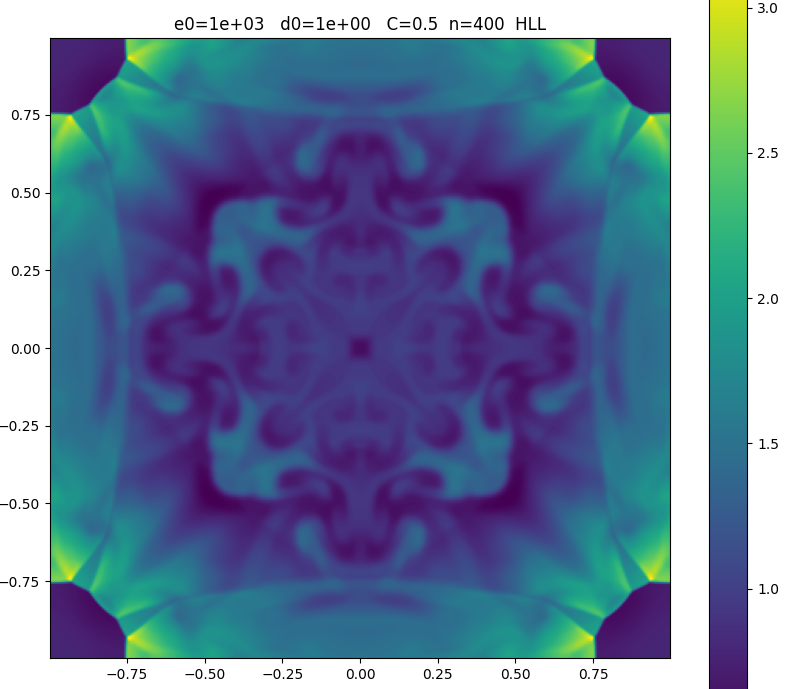

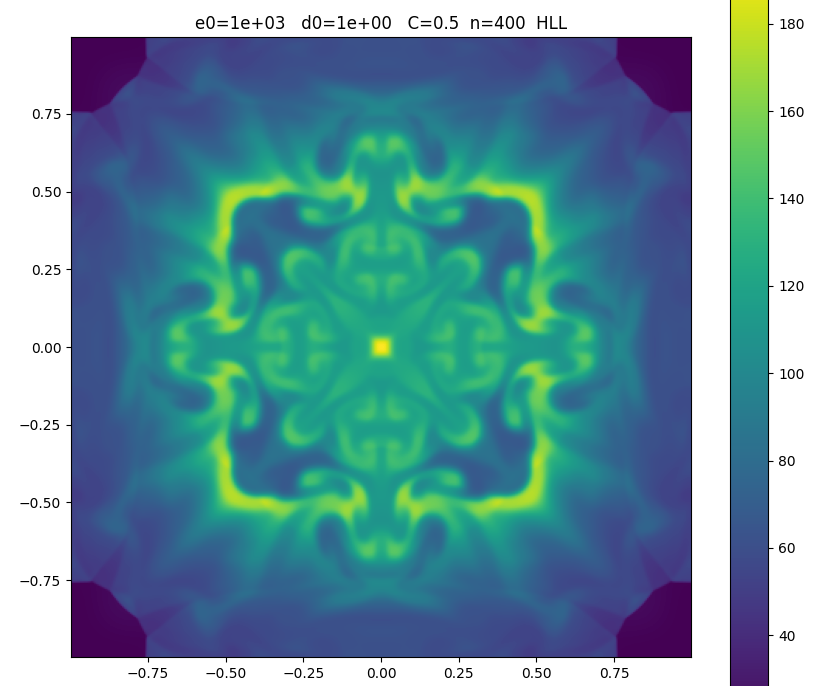

${\bf Bonus\ Tasks}$

We tried to simulate a blast wave where half of the box has a different density from the background. In our case we chose 5 times bigger than the initial one. The results are depicted below. We expecting that, since the density on the right side of the blast wave is bigger (denser), the velocity of the blast wave is decreasing as it becomes harder and harder for the shock front to move along. Also due to the blast wave, more and more mass is accumulating and thus we are expecting denser front regions.

Even though, there was some kind of trouble with coding two different blast waves and the blast wave on the edge and inside of a molecular cloud we could exlpain what we are expecting. In the case of a blast wave taking place outside a dense region, nothing will occure as the wave might not reach this specific region. If it is on the edge of it, the blast wave might travel through the region but it will attenuate with time, as the sound speed of the system will change.

In [15]:
class hd2():
    """ Template class for hydrodynamics, with parameters, variables and methods """
    def __init__(self,n=64,gamma=1.4,Lbox=2.,cs=None):
        """ Initialization of arrays for conservative variables """
        self.n=n                     # number of points along a coordinate axis. n*n in total
        self.Lbox=Lbox               # box size
        self.t = 0.                  # time
        self.it = 0                  # iterations
        self.gamma = gamma           # adiabatic index
        if gamma==1:                 # only set sound speed if gas isothermal
            self.cs = cs
        self.rho   = np.ones((n,n))  # density
        self.Etot  = np.ones((n,n))  # total energy
        self.Px    = np.zeros((n,n)) # momentum in x-direction
        self.Py    = np.zeros((n,n)) # momentum in y-direction
        self.coordinates()           # setup cooridnate system
    
    def coordinates(self):
        """ Coordinate initialization """
        n = self.n              # shorthand, used a lot below
        self.ds = self.Lbox/n
        self.dx = self.ds
        self.dy = self.ds
        # cell-centered coordinates are in the interval [-1+ds/2,...,1-ds/2]
        self.x = 5*np.linspace(-self.Lbox*0.5,self.Lbox*0.5,num=self.n,endpoint=False)+0.5*self.ds 
        self.y = self.x
        # make a 2D radius function for convenience
        self.r = np.zeros((n,n))
        for i in range(n):
            self.r[i] = (self.y**2 + self.x[i]**2)**0.5 
        return self.ds,self.r
    def velocity(self):
        """ Compute velocity from conservative variables and return in (2,n,n) array """
        return np.array([self.Px/self.rho, self.Py/self.rho])

    def pressure(self):
        """ Compute pressure from conservative variables """
        if (self.gamma==1.0):
            P = self.cs**2 * self.rho
        else:
            Eint = self.Etot - 0.5*(self.Px**2 + self.Py**2)/self.rho 
            P = (self.gamma-1.)*Eint
        return P

    def temperature(self):
        """ Compute the 'temperature', defined as P/rho = kB / mu T """
        return self.pressure() / self.rho
    
    def Courant(self,C=0.5):
        """ Courant condition for HD """
        v = self.velocity()
        speed = np.sqrt(v[0]**2 + v[1]**2)
        cs = np.sqrt(self.gamma*self.pressure()/self.rho)
        return C*self.ds/np.max(cs+speed)

In [46]:
class blast_wave3(hd):
    def __init__(u,n=64,gamma=1.4,e0=1e3,d0=0.0,power=2,w=3.,eps=0.7):
        hd.__init__(u,n)
        u.gamma = gamma
        exponent=(np.exp(-u.r/(w*u.ds)))**power
        B=1/np.sum(exponent*u.ds*u.ds)
        profile =B*e0*exponent
        u.Etot = np.ones((n,n)) + profile
        u.rho  = np.ones((n,n)) 
        for i in range(n):
            if u.x[i]>0:
                u.rho[i]*=5
       

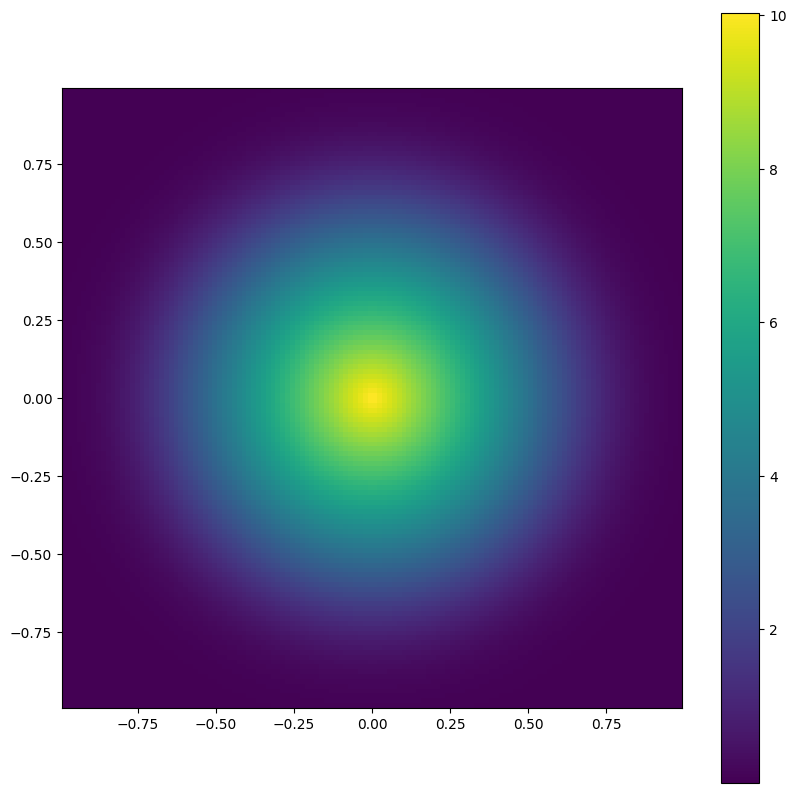

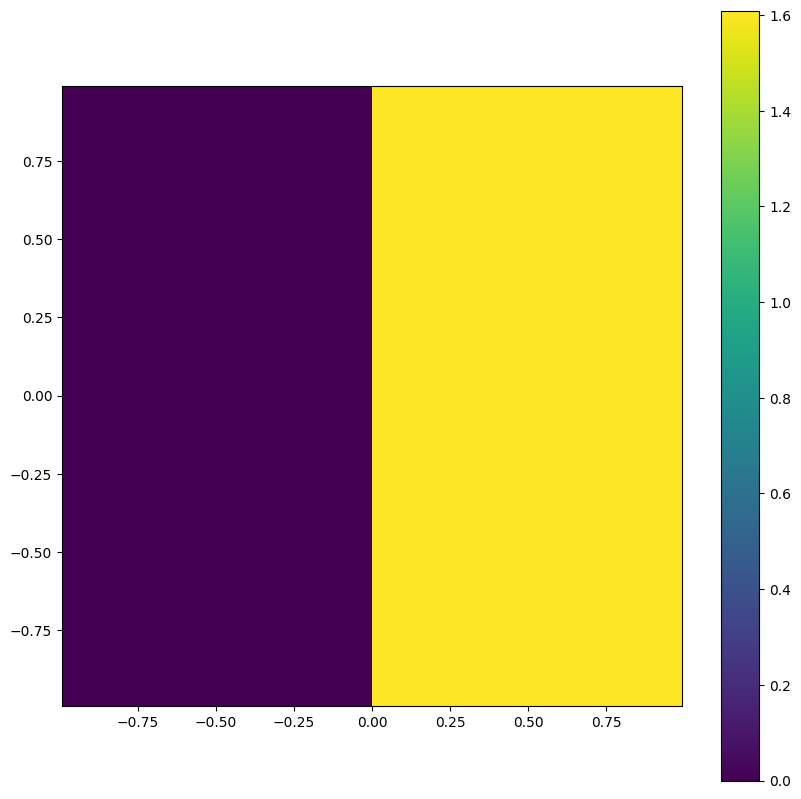

In [47]:
u = blast_wave3(n=128,w=10)
imshow(np.log(u.Etot),axis=u.x)
imshow(np.log(u.rho),axis=u.x)

27.2 sec, 0.76 microseconds/update


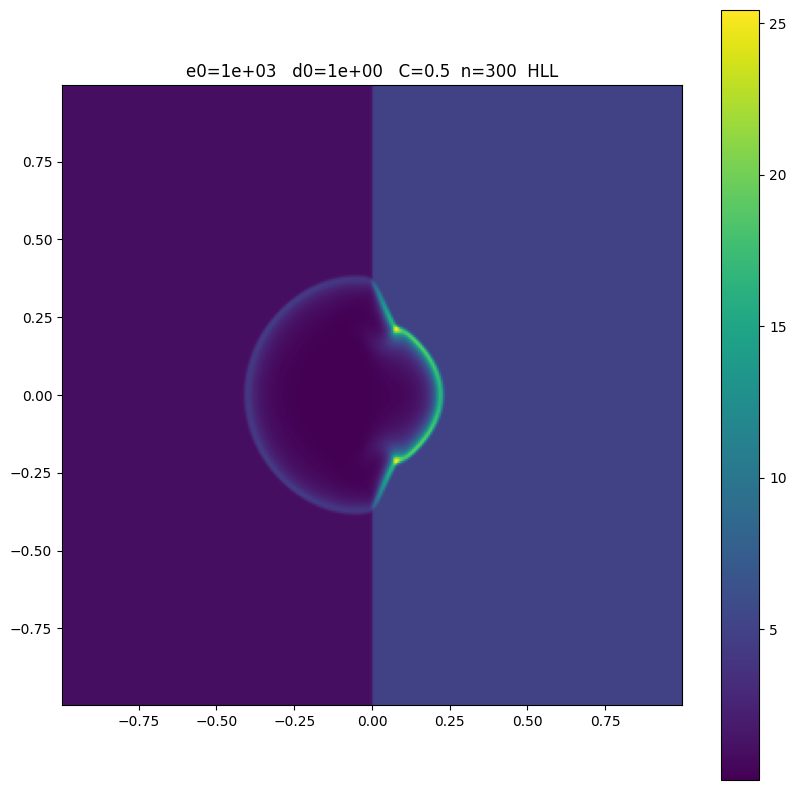

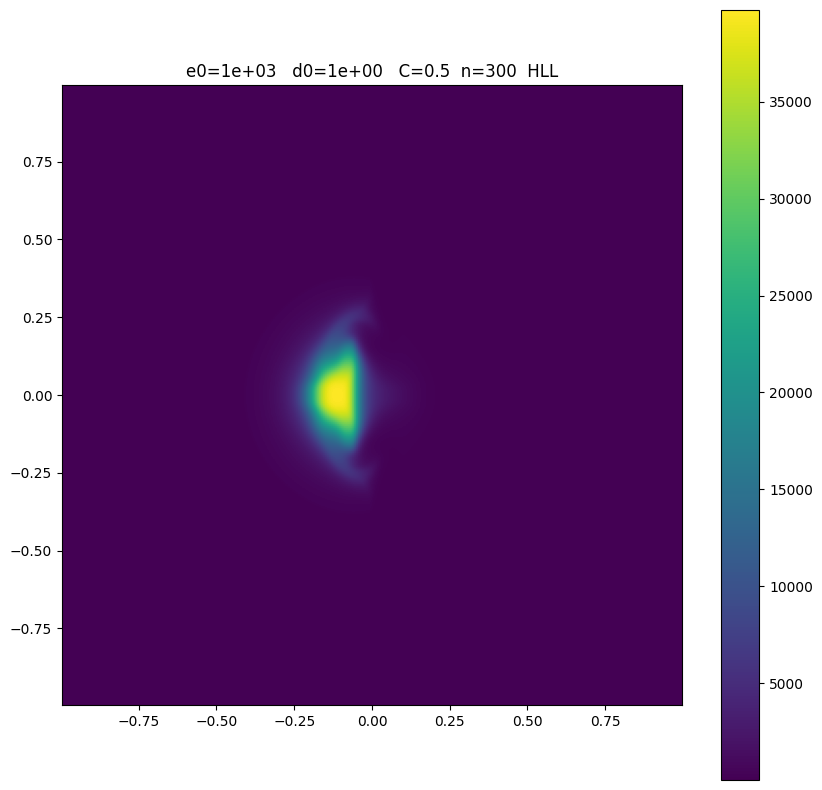

In [48]:
e0 = 1e3
n = 300
C = 0.5
nt = 400
solver = HLL
u3 = blast_wave3(n=n,e0=e0,gamma=1.4,w=3.,power=4,eps=0.1)
start = time()
u3_sol=[]
u3t_sol=[]
u3E_sol=[]
for it in range(nt):
    dt=u3.Courant(C)
    u3 = muscl_2d(u3,dt,Slope=MonCen,Riemann_Solver=solver)
    u3_sol.append(np.copy(u3.rho))
    u3t_sol.append(np.copy(u3.t))
    u3E_sol.append(np.copy(u3.Etot))

u3_sol=np.asarray(u1_sol)

    
    
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*nt)))
imshow(u3.rho,axis=u3.x)
title(e0=e0,C=C,n=n,solver=solver)
imshow(u3.temperature(),axis=u3.x)
title(e0=e0,C=C,n=n,solver=solver)

#### Trying to simulate the blast inside a region of different density.



We tried to create a spherical density region but we could not manage to do so. Thus we chose that kind of idea, as a closer replica for a blast wave inside a molecular cloud (dense region). The result is that during the blast, the wave front sweps the mass of the region resulting into accumulation of it, while the wave is moving from the inner to outer regions. This case takes place all along the spherical wave front. Of course such a system, could also perturbate the system of the molecular cloud, leading to the formation of dense topical regions.

In [63]:
class blast_wave4(hd):
    def __init__(u,n=64,gamma=1.4,e0=1e3,d0=0.0,power=2,w=3.,eps=0.5):
        hd.__init__(u,n)
        u.gamma = gamma
        exponent=(np.exp(-u.r/(w*u.ds)))**power
        B=1/np.sum(exponent*u.ds*u.ds)
        profile =B*e0*exponent
        u.Etot = np.ones((n,n)) + profile
        u.rho  = np.ones((n,n)) 
        for i in range(n):
            if u.x[i]>-2 and u.x[i]<2:
                u.rho[80:110,i]*=6
                

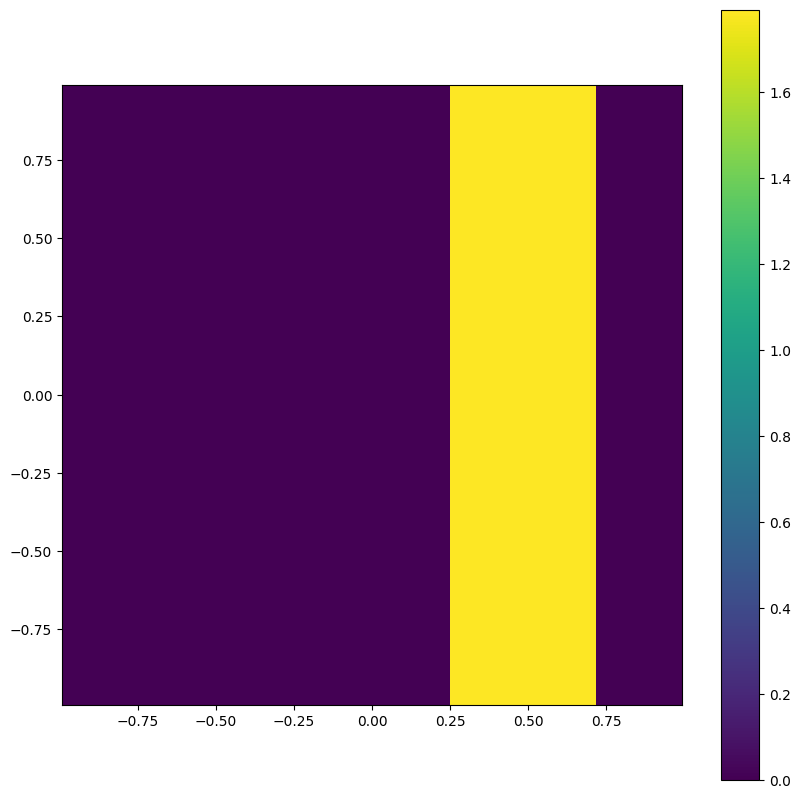

In [65]:
u = blast_wave4(n=128,w=10)
imshow(np.log(u.rho),axis=u.x)

4.6 sec, 0.57 microseconds/update


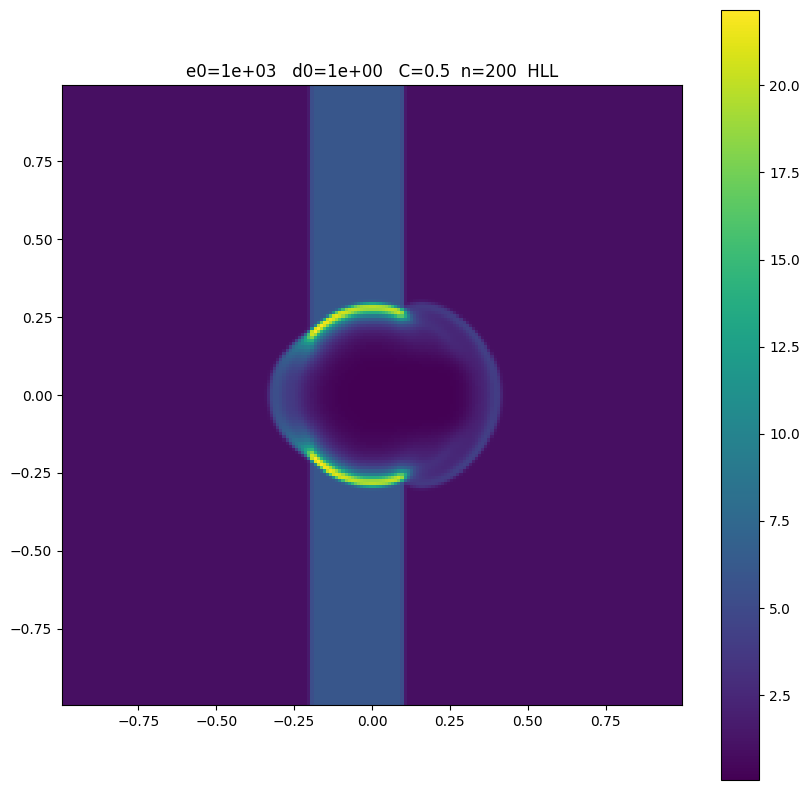

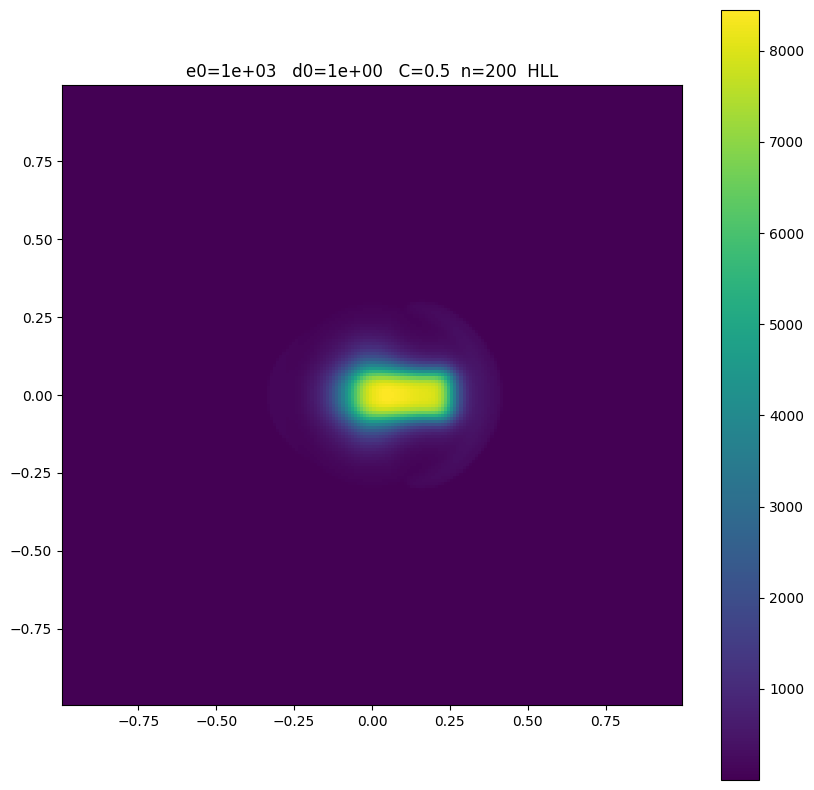

In [66]:
e0 = 1e3
n = 200
C = 0.5
nt = 200
solver = HLL
u4 = blast_wave4(n=n,e0=e0,gamma=1.4,w=3.,power=4,eps=0.1)
start = time()

for it in range(nt):
    dt=u4.Courant(C)
    u4 = muscl_2d(u4,dt,Slope=MonCen,Riemann_Solver=solver)
    
    
    
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*nt)))
imshow(u4.rho,axis=u4.x)
title(e0=e0,C=C,n=n,solver=solver)
imshow(u4.temperature(),axis=u4.x)
title(e0=e0,C=C,n=n,solver=solver)